## Imports

In [ ]:
# Basics
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Word Embedding
import gensim
from nltk.stem import PorterStemmer

# Preprocessing
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import *


# Sklearn models
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline




## Dataset preprocessing

In [ ]:
df = pd.read_csv("cyberbullying_tweets.csv")

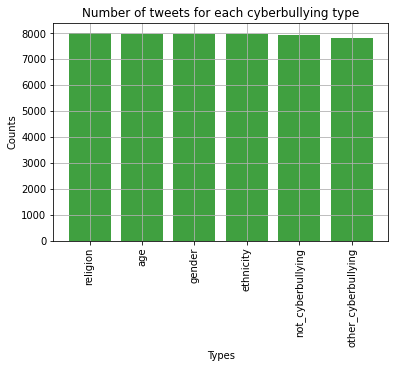

In [ ]:
index = df.cyberbullying_type.value_counts().index.tolist()
values = df.cyberbullying_type.value_counts().values.tolist()

plt.bar(index, values, facecolor='g', alpha=0.75)

plt.xlabel('Types')
plt.ylabel('Counts')
plt.title('Number of tweets for each cyberbullying type')
# Rotation of the bar names
plt.xticks(index, rotation=90)
# plt.subplot_adjust(bottom=0.01, top=0.99)

plt.grid(True)
plt.show()

### Creation of the label array

In [ ]:
types = {'age':0,
         'ethnicity':0,
         'gender':0,
         'not_cyberbullying':1,
         'other_cyberbullying':0,
         'religion':0}


Y = df.iloc[::,1].to_numpy()
Y = [types[y] for y in Y]
Y = np.reshape(Y, (len(Y), 1))
X = df.iloc[::,0].to_numpy()


X = [''.join(item.lower() for item in x if item.isalpha() or item == " ") for x in X]
X = [x.split(" ") for x in X] 




### Stemming / Lemmetising

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

### PARAMETERS ###
# if stemming, else lemmatizing words
use_stemm = True
# dimension vectors needed
dimension_selected = 100

##################
# stop words
list_stp_wrd = stopwords.words('english')

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Init stemmer
stemmer = PorterStemmer()
# set were we get the new dataset with lemmatize words
lemmatize_X = []

#for each sentence (list of word)
mapping = [ ('\d+', ''), ('https?:', ''), ('http?:', '') ]
for sentence_wrd in X:

    # Tokenisation, here we keep only alphabetic values for the moment
    sentence_wrd = [x  for x in sentence_wrd if x not in list_stp_wrd]

    # Tokenisation, here we eliminate mentions
    sentence_wrd = [x  for x in sentence_wrd if not x.startswith('@')]

    # Tokenisation, here we eliminate links
    for k, v in mapping:
        sentence_wrd = str(sentence_wrd).replace(k, v)
        
    # we lemmatize each wrd
    if use_stemm:
        # stemming if necessary
        lemm_sentence_wrd = [stemmer.stem(wrd) for wrd in sentence_wrd]
    else:
        # else lemmatize
        lemm_sentence_wrd = [lemmatizer.lemmatize(wrd) for wrd in sentence_wrd]
        
    lemmatize_X.append(lemm_sentence_wrd)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Creation of the input array

In [ ]:
# size of the Embedded array
embbed_size = 25

cbow = gensim.models.Word2Vec(
            X,
            size=embbed_size, # desired no. of features/independent variables
            window=8, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 0, # 0 for cbow
            hs = 0, # to enable negative sampling
            negative = 10, # for negative sampling
            cbow_mean = 1, # use the mean instead of the sum
            workers= 32, # no.of cores
            seed = 42) 

cbow.train(X, total_examples=len(X), epochs=20)

(17150612, 22638920)

### Sentence Embedding

In [ ]:
# A sentence is represented by the mean of the words embedding it contains
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += cbow.wv[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

wordvec_arrays = np.zeros((len(X), embbed_size)) 
for i in range(len(X)):
    wordvec_arrays[i,:] = word_vector(X[i], embbed_size)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape


(47692, 25)

## Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(wordvec_df, Y, test_size=0.30, random_state=42)
X_train = X_train.values.tolist()
X_test = X_test.values.tolist()

## Models

In [ ]:
def display_top(results):

  results_df = pd.DataFrame(results)
  results_df = results_df.sort_values(by=["rank_test_score"])
  results_df = results_df.set_index(
      results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
      ).rename_axis("kernel")
  top = results_df[[ "rank_test_score", "mean_test_score", "std_test_score"]]

  print(top[:10])

### sklearn - Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
DT = Pipeline([('dt', dt)])


parameters = {
              'dt__max_depth': [8, 10, 12],
              'dt__min_samples_split': [2, 3, 4],
              'dt__min_samples_leaf': [2, 4, 6]
              }


      
grid_DT = GridSearchCV(DT, parameters, verbose=0, return_train_score=True)
grid_DT = grid_DT.fit(X_train, y_train)


best_par = grid_DT.best_estimator_.get_params()

print("Best model: ",
      '\n Max Depth = ', best_par['dt__max_depth'],
      '\n Min Samples Split = ', best_par['dt__min_samples_split'],
      '\n Min Samples Leaf = ', best_par['dt__min_samples_leaf']
      )

best_score = grid_DT.score(X_test, y_test)
print("Best DT model score: ", best_score)

results = grid_DT.cv_results_
print("the best Models: \n")
display_top(results)

Best model:  
 Max Depth =  8 
 Min Samples Split =  2 
 Min Samples Leaf =  2
Best DT model score:  0.8489656136427174
the best Models: 

        rank_test_score  mean_test_score  std_test_score
kernel                                                  
8_2_2                 1         0.852055        0.002139
8_2_3                 1         0.852055        0.002139
8_2_4                 1         0.852055        0.002139
8_4_2                 4         0.851845        0.002570
8_4_3                 4         0.851845        0.002570
8_4_4                 4         0.851845        0.002570
8_6_2                 7         0.851845        0.002151
8_6_3                 7         0.851845        0.002151
8_6_4                 7         0.851845        0.002151
10_2_2               10         0.844716        0.003548


### sklearn - Random Forest

In [ ]:
rf = RandomForestClassifier()

RF = Pipeline([('rf', rf)])

parameters = {
              'rf__n_estimators': [70, 100],
              'rf__max_depth': [10, 15, 20],
              'rf__min_samples_leaf': [4, 6, 10],
              'rf__min_samples_split': [2, 4, 6],
              }


grid_RF = GridSearchCV(RF, parameters, verbose=0, return_train_score=True)
grid_RF = grid_RF.fit(X_train, y_train.ravel())


best_par = grid_RF.best_estimator_.get_params()

print("Best model: ",
      '\n Number of Estimators = ', best_par['rf__n_estimators']
      )

best_score = grid_RF.score(X_test, y_test.ravel())
print("Best RF model score: ", best_score)

results = grid_RF.cv_results_
print("The best Models: \n")
display_top(results)

Best model:  
 Number of Estimators =  70
Best RF model score:  0.8581912216941571
The best Models: 

             rank_test_score  mean_test_score  std_test_score
kernel                                                       
10_10_2_70                 1         0.861011        0.001558
10_6_4_70                  2         0.861011        0.001404
10_10_6_70                 3         0.860862        0.002218
10_6_2_100                 4         0.860862        0.001999
10_10_6_100                5         0.860832        0.001633
10_10_4_100                6         0.860832        0.001786
15_10_4_100                7         0.860742        0.001093
10_4_6_100                 8         0.860712        0.001964
10_4_4_70                  9         0.860712        0.002083
15_10_4_70                10         0.860712        0.002111


In [ ]:
rf = RandomForestClassifier()

RF = Pipeline([('rf', rf)])

parameters = {
              'rf__n_estimators': [50, 70],
              'rf__max_depth': [5, 8, 10],
              'rf__min_samples_leaf': [8, 10, 15],
              'rf__min_samples_split': [2, 4],
              }


grid_RF2 = GridSearchCV(RF, parameters, verbose=0, return_train_score=True)
grid_RF2 = grid_RF2.fit(X_train, y_train.ravel())


best_par = grid_RF2.best_estimator_.get_params()

print("Best model: ",
      '\n Number of Estimators = ', best_par['rf__n_estimators'],
      '\n Max Depth = ', best_par['rf__max_depth'],     
      '\n Min samples leaf = ', best_par['rf__min_samples_leaf'],
      '\n Min amples split = ', best_par['rf__min_samples_split'],
      )

best_score = grid_RF2.score(X_test, y_test.ravel())
print("Best RF model score: ", best_score)

results = grid_RF2.cv_results_
print("The best Models: \n")
display_top(results)

Best model:  
 Number of Estimators =  70 
 Max Depth =  10 
 Min samples leaf =  15 
 Min amples split =  2
Best RF model score:  0.8572826390830305
The best Models: 

            rank_test_score  mean_test_score  std_test_score
kernel                                                      
10_15_2_70                1         0.860832        0.002276
10_10_2_70                2         0.860772        0.001650
10_10_4_50                3         0.860742        0.001783
10_15_2_50                4         0.860712        0.002043
10_15_4_70                5         0.860622        0.001575
10_10_2_50                6         0.860532        0.001555
10_8_4_70                 7         0.860502        0.002312
10_15_4_50                8         0.860382        0.001866
10_8_2_50                 9         0.860262        0.001760
10_8_2_70                10         0.860262        0.000985


In [ ]:
rf = RandomForestClassifier()

RF = Pipeline([('rf', rf)])

parameters = {
              'rf__n_estimators': [70],
              'rf__max_depth': [10, 13],
              'rf__min_samples_leaf': [12, 15, 20],
              'rf__min_samples_split': [2, 4],
              }


grid_RF2 = GridSearchCV(RF, parameters, verbose=0, return_train_score=True)
grid_RF2 = grid_RF2.fit(X_train, y_train.ravel())


best_par = grid_RF2.best_estimator_.get_params()

print("Best model: ",
      '\n Number of Estimators = ', best_par['rf__n_estimators'],
      '\n Max Depth = ', best_par['rf__max_depth'],     
      '\n Min samples leaf = ', best_par['rf__min_samples_leaf'],
      '\n Min amples split = ', best_par['rf__min_samples_split'],
      )

best_score = grid_RF2.score(X_test, y_test.ravel())
print("Best RF model score: ", best_score)

results = grid_RF2.cv_results_
print("The best Models: \n")
display_top(results)

Best model:  
 Number of Estimators =  70 
 Max Depth =  10 
 Min samples leaf =  12 
 Min amples split =  4
Best RF model score:  0.8571428571428571
The best Models: 

            rank_test_score  mean_test_score  std_test_score
kernel                                                      
10_12_4_70                1         0.861341        0.001870
13_20_2_70                2         0.861311        0.001641
10_15_2_70                3         0.861251        0.001681
13_12_2_70                4         0.861191        0.001906
13_15_4_70                5         0.861161        0.001953
13_15_2_70                6         0.861131        0.001964
10_15_4_70                7         0.860921        0.001745
13_20_4_70                8         0.860891        0.001932
13_12_4_70                9         0.860772        0.001440
10_20_2_70               10         0.860472        0.001941


In [ ]:
rf = RandomForestClassifier()

RF = Pipeline([('rf', rf)])

parameters = {
              'rf__n_estimators': [70],
              'rf__max_depth': [10, 11],
              'rf__min_samples_leaf': [13, 14]
              }


grid_RF2 = GridSearchCV(RF, parameters, verbose=0, return_train_score=True)
grid_RF2 = grid_RF2.fit(X_train, y_train.ravel())


best_par = grid_RF2.best_estimator_.get_params()

print("Best model: ",
      '\n Number of Estimators = ', best_par['rf__n_estimators'],
      '\n Max Depth = ', best_par['rf__max_depth'],     
      '\n Min samples leaf = ', best_par['rf__min_samples_leaf'],
      '\n Min amples split = ', best_par['rf__min_samples_split'],
      )

best_score = grid_RF2.score(X_test, y_test.ravel())
print("Best RF model score: ", best_score)

results = grid_RF2.cv_results_
print("The best Models: \n")
display_top(results)

Best model:  
 Number of Estimators =  70 
 Max Depth =  11 
 Min samples leaf =  13 
 Min amples split =  2
Best RF model score:  0.8572826390830305
The best Models: 

          rank_test_score  mean_test_score  std_test_score
kernel                                                    
11_13_70                1         0.861161        0.002144
11_14_70                2         0.860921        0.001673
10_14_70                3         0.860682        0.001539
10_13_70                4         0.860143        0.002225


### sklearn - Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier


bag = BaggingClassifier(DecisionTreeClassifier()) #, max_samples=0.5, n_estimators=100)

BAG = Pipeline([
               ('bag', bag)])

parameters = {'bag__n_estimators': [100, 150],
              'bag__max_samples': [0.4, 0.8],
              'bag__max_features': [0.4, 0.8],
              }



grid_BAG = GridSearchCV(BAG, parameters, verbose=0, return_train_score=True)
grid_BAG = grid_BAG.fit(X_train, y_train.ravel())

best_par = grid_BAG.best_estimator_.get_params()

print("Best model: ",
      '\n Number of Estimators = ', best_par['bag__n_estimators'],
      '\n Max Samples = ', best_par['bag__max_samples'],
      '\n Max features = ', best_par['bag__max_features'],      
      )

best_score = grid_BAG.score(X_test, y_test.ravel())
print("Best BAG model score: ", best_score)

results = grid_BAG.cv_results_
print("The best Models: \n")
display_top(results)

Best model:  
 Number of Estimators =  150 
 Max Samples =  0.4 
 Max features =  0.8
Best BAG model score:  0.848825831702544
The best Models: 

             rank_test_score  mean_test_score  std_test_score
kernel                                                       
0.8_0.4_150                1         0.854691        0.002002
0.8_0.4_100                2         0.854002        0.002114
0.4_0.4_150                3         0.851246        0.002842
0.4_0.4_100                4         0.850617        0.001473
0.8_0.8_100                5         0.849838        0.000986
0.8_0.8_150                6         0.848610        0.001727
0.4_0.8_150                7         0.845165        0.002099
0.4_0.8_100                8         0.845016        0.001749


In [ ]:
from sklearn.ensemble import BaggingClassifier


bag = BaggingClassifier(DecisionTreeClassifier()) #, max_samples=0.5, n_estimators=100)

BAG = Pipeline([
               ('bag', bag)])

parameters = {'bag__n_estimators': [150],
              'bag__max_samples': [0.3, 0.2],
              'bag__max_features': [10, 1],
              }



grid_BAG = GridSearchCV(BAG, parameters, verbose=0, return_train_score=True)
grid_BAG = grid_BAG.fit(X_train, y_train.ravel())

best_par = grid_BAG.best_estimator_.get_params()

print("Best model: ",
      '\n Number of Estimators = ', best_par['bag__n_estimators'],
      '\n Max Samples = ', best_par['bag__max_samples'],
      '\n Max features = ', best_par['bag__max_features'],      
      )

best_score = grid_BAG.score(X_test, y_test.ravel())
print("Best BAG model score: ", best_score)

results = grid_BAG.cv_results_
print("The best Models: \n")
display_top(results)

Best model:  
 Number of Estimators =  150 
 Max Samples =  0.2 
 Max features =  10
Best BAG model score:  0.852390271176964
The best Models: 

            rank_test_score  mean_test_score  std_test_score
kernel                                                      
10_0.2_150                1         0.857956        0.000865
10_0.3_150                2         0.855290        0.001701
1_0.2_150                 3         0.836778        0.000250
1_0.3_150                 4         0.836718        0.000249


### sklearn - Gradient Boosting

In [ ]:

gbc = GradientBoostingClassifier() 
GBC = Pipeline([
               ('gbc', gbc)])


parameters = {
              'gbc__n_estimators': [100, 150],
              'gbc__learning_rate' : [0.1, 1]              
              }



grid_GBC = GridSearchCV(GBC, parameters, verbose=0, return_train_score=True)
grid_GBC = grid_GBC.fit(X_train, y_train.ravel())


best_par = grid_GBC.best_estimator_.get_params()

print("Best Gradient Boosting Classifier model: ",
      '\n Number of Estimators = ', best_par['gbc__n_estimators']
      )

best_score = grid_GBC.score(X_test, y_test.ravel())
print("Best Gradient Boosting Classifier model score: ", best_score)

results_gbc = grid_GBC.cv_results_
print("The best Models: \n")
display_top(results_gbc)

Best Gradient Boosting Classifier model:  
 Number of Estimators =  150
Best Gradient Boosting Classifier model score:  0.7567095331283198
The best Models: 

         rank_test_score  mean_test_score  std_test_score
kernel                                                   
0.1_150                1         0.761772        0.003309
0.1_100                2         0.757039        0.002938
1_100                  3         0.733375        0.004281
1_150                  4         0.731818        0.005670


### sklearn - ADA Boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(DecisionTreeClassifier()) 

ADA = Pipeline([
               ('ada', ada)])


parameters = {
              'ada__n_estimators': [100, 150],
              'ada__learning_rate' : [0.1, 1]              
              }



grid_ADA = GridSearchCV(ADA, parameters, verbose=0, return_train_score=True)
grid_ADA = grid_ADA.fit(X_train, y_train.ravel())


best_par = grid_ADA.best_estimator_.get_params()

print("Best model: ",
      '\n Number of Estimators = ', best_par['ada__n_estimators']
      )

best_score = grid_ADA.score(X_test, y_test.ravel())
print("Best AdaBoost model score: ", best_score)

results_ada = grid_ADA.cv_results_
print("The Best Models: \n")
display_top(results_ada)

Best model:  
 Number of Estimators =  150
Best AdaBoost model score:  0.7456667598546268
The Best Models: 

         rank_test_score  mean_test_score  std_test_score
kernel                                                   
1_150                  1         0.756171        0.001924
1_100                  2         0.753235        0.003496
0.1_150                3         0.739606        0.007658
0.1_100                4         0.720645        0.014811
